## Modelling

In [1]:
from __future__ import division
from pyomo.environ import *
from math import pi as PI
from math import cos as COS
from math import sin as SIN

In [2]:
m = 10  # number of grid points
K = 2   # problem dimensionality

In [3]:
def solve(beta):
    model = ConcreteModel()

    # generic variables
    model.z = Var(domain=Reals, initialize=0.05) # init with z=0 fails on 1st step. refer article
    model.OBJ = Objective(expr = model.z, sense=minimize)

    # problem specific variables
    model.x1 = Var(domain=Reals, bounds=(0,PI))
    model.x2 = Var(domain=Reals, bounds=(0,PI))
    f = (model.x1, model.x2)     # multicriterion objective function

    # add generic beta constraints
    model.DIM = RangeSet(0,K-1)
    def beta_constraint(model, i):
        return model.z*beta[i] >= f[i]
    model.beta_const = Constraint(model.DIM,rule=beta_constraint)

    # add problem specific feasibility constraints
    model.C1 = Constraint(expr = (model.x1-0.5)**2 + (model.x2-0.5)**2 <= 0.5)
    model.C2 = Constraint(expr = model.x1**2 + model.x2**2 -1 -0.1*cos(16*atan(model.x1/model.x2))>= 0)
    
    # model.pprint()
    
    # solve on NEOS solver 
    solver_manager = SolverManagerFactory('neos')
    results = solver_manager.solve(model, opt='knitro')
    
#     print(results)
    
    if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
        return value(model.OBJ)
    elif results.solver.termination_condition == TerminationCondition.infeasible:
        return 0
    else:
        return 0

## Simulation

In [4]:
# do the simulation
points = []

for i in range(m+1): # 0,m inclusive
    theta1 = (i*PI)/(4*m)
    beta = (COS(theta1), SIN(theta1))
    tmp = solve(beta)
    print("iter %d: z=%f" % (i,tmp))
    points.append((tmp,beta))

ERROR: Error loading NEOS solution into model  NEOS log: Job 7623117
    dispatched password: YXJIBGbk ---------- Begin Solver Output -----------
    Condor submit: 'neos.submit' Condor submit: 'watchdog.submit' Job
    submitted to NEOS HTCondor pool.
ERROR: Knitro 11.1.0: Evaluation error.
ERROR: objective 0; feasibility error 1
ERROR: feaserror
ERROR: opterror
iter 0: z=0.000000
iter 1: z=1.015333
iter 2: z=0.958696
iter 3: z=0.955448
iter 4: z=0.976860
iter 5: z=1.048809
iter 6: z=1.015333
iter 7: z=0.958696
iter 8: z=0.958696
iter 9: z=1.015333
iter 10: z=1.048809


## Plotting result

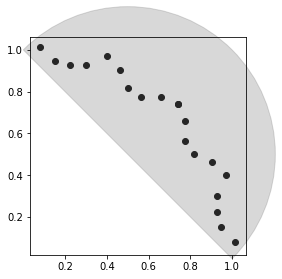

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as pat

fig, ax = plt.subplots()
ax.set_aspect('equal')

# drawing the circle
circle = pat.Wedge((0.5,0.5), 0.707,-45,135,color='grey')
circle.set_clip_on(False)
circle.set_alpha(0.3)
ax.add_artist(circle)

for z, beta in points:
    if z > 0: # coz the function is symmetric
        plt.scatter(z*beta[0], z*beta[1], color='black')
        plt.scatter(z*beta[1], z*beta[0], color='black')
plt.show()